In [ ]:
!pip install transformers datasets pandas matplotlib spacy -q
!pip install -q git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.3 MB/s eta 0:00:00


In [ ]:
!python -m spacy download pt_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 3.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from datetime import datetime
from collections import Counter
from tqdm.notebook import tqdm
import re

In [ ]:
df = pd.read_csv('articles.csv')
df.head()
df_original = pd.read_csv('articles.csv')

In [ ]:
# Converter a coluna 'date' para datetime corretamente
df_original['date'] = pd.to_datetime(df_original['date'], errors='coerce')

# Filtrar categoria mercado
df = df_original[df_original['category'].str.lower().str.strip() == 'mercado']

# Filtrar por trimestre de 2015
df = df[df['date'].between('2015-01-01', '2015-03-31')]


In [ ]:
model_name = "monilouise/ner_pt_br"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at monilouise/ner_pt_br were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [ ]:
org_counter = Counter()
stopwords = {"o", "a", "s", "os", "as", "um", "uma", "##i", "##bc", ""}  # palavras comuns e tokens errados

In [ ]:


for text in tqdm(df['text'].dropna()):
    entities = ner_pipeline(text[:512])  # limitar a 512 tokens
    for ent in entities:
        if ent['entity_group'] == 'ORG':
            org_name = ent['word'].strip()
            org_name_clean = re.sub(r'[^\w\s&]', '', org_name).lower().strip()
            if len(org_name_clean) > 2 and org_name_clean not in stopwords:
                org_counter[org_name_clean] += 1

  0%|          | 0/2111 [00:00<?, ?it/s]

In [ ]:
org_df = pd.DataFrame(org_counter.items(), columns=["Organização", "Frequência"])
org_df = org_df.sort_values(by="Frequência", ascending=False).reset_index(drop=True)

In [ ]:
org_df.head(10)

,Organização,Frequência
0,folha,217
1,brasil,45
2,moody,30
3,sete,25
4,bm &,23
5,vale,22
6,google,22
7,fbovespa,21
8,letras,19
9,bovespa,17


VISUALIZAÇÃO


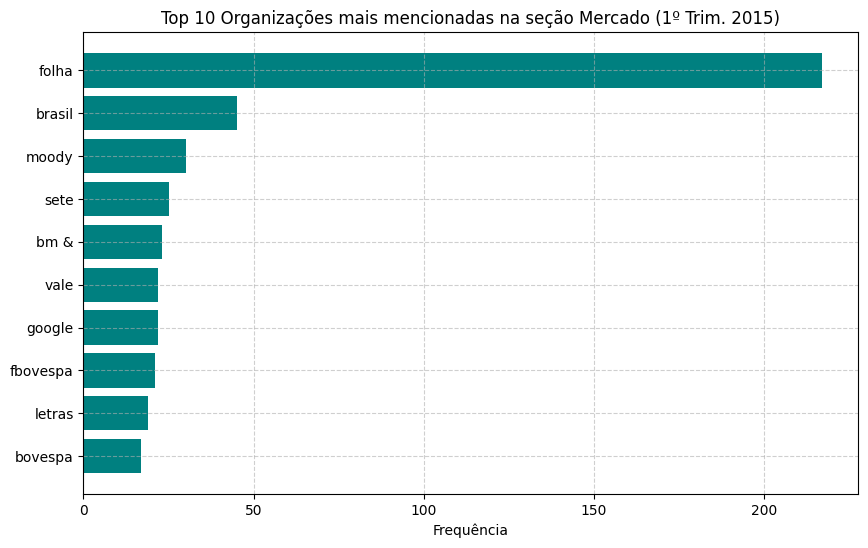

In [ ]:
top10 = org_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top10["Organização"], top10["Frequência"], color='teal')
plt.xlabel("Frequência")
plt.title("Top 10 Organizações mais mencionadas na seção Mercado (1º Trim. 2015)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
df_original = pd.read_csv('articles.csv')

print(df_original['category'].value_counts())


category
poder                           22022
colunas                         21622
mercado                         20970
esporte                         19730
mundo                           17130
cotidiano                       16967
ilustrada                       16345
opiniao                          4525
paineldoleitor                   4011
saopaulo                         3955
tec                              2260
tv                               2142
educacao                         2118
turismo                          1903
ilustrissima                     1411
ciencia                          1335
equilibrioesaude                 1312
sobretudo                        1057
bbc                               980
folhinha                          876
empreendedorsocial                841
comida                            828
asmais                            548
ambiente                          491
seminariosfolha                   379
serafina                          334
o-m

In [ ]:
print(df_original['date'].min(), df_original['date'].max())



2015-01-01 2017-10-01


In [ ]:
df['date'].head()



,date
99055,2015-03-12
99063,2015-03-12
99064,2015-03-12
99074,2015-03-12
99076,2015-03-12
